<a href="https://colab.research.google.com/github/jylee9018/TIL-Tasks/blob/main/(1%EC%A3%BC%EC%B0%A8_%EA%B8%B0%EB%B3%B8)_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 1주차 기본과제: MNIST
- 제출일: 2025.03.28.

### 0. Importing Libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

### 1. Datasets & Data loaders
with the following parameters:
- `root` is the path where the train/test data is stored,
- `train` specifies training or test dataset,
- `download=True` downloads the data from the internet if it’s not available at root.
- `transform` and `target_transform` specify the feature and label transformations

In [2]:
# Download training data from open datasets.
train_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


60000
2
1
28
28
torch.Size([1, 28, 28]) 5


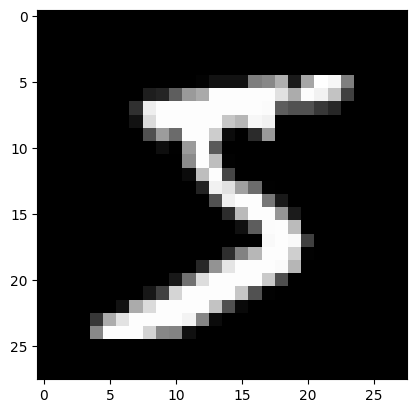

In [54]:
print(len(train_data))
print(len(train_data[0]))
print(len(train_data[0][0]))
print(len(train_data[0][0][0]))
print(len(train_data[0][0][0][0]))
print(train_data[0][0].shape, train_data[0][1])

plt.imshow(train_data[0][0][0], cmap='gray')

In [28]:
X, y = train_data[0]            # 첫 번째 데이터포인트
print(f"Shape of X: {X.shape}") # 이미지 텐서의 Shape 출력
print(f"Label: {y}")            # 해당 이미지의 정답 레이블 출력

Shape of X: torch.Size([1, 28, 28])
Label: 5


In [5]:
 # batch_size = 64
batch_size=256

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"train data loder")
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"\ntest data loder")
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train data loder
Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64

test data loder
Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64


### 2. Creating Models

In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)  # n_dim은 실험의 영역
    self.layer2 = nn.Linear(n_dim, n_dim)
    # self.layer3 = nn.Linear(n_dim, 1)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024).to(device)
print(model)

Using cuda device
Model(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
  (act): ReLU()
)


### 3. Optimizing the Model Parameters

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
# 손실 및 정확도 저장 리스트
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    total_loss, correct, total = 0., 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 및 손실 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파(Backpropagation)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 손실 및 정확도 계산
        total_loss += loss.item()  # 배치의 손실을 누적
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    # 훈련 데이터 정확도 저장
    train_accuracy = correct / total * 100
    train_accuracies.append(train_accuracy)

    # 평균 손실 반환
    return total_loss / size  # 데이터셋 크기로 나눠 평균 손실 반환

##### `argmax(dim=n)`:


    - 특정 차원(dim)에서 최댓값을 갖는 인덱스(index) 반환
    - PyTorch
        - `torch.argmax()`
    - Numpy
        - `np.argmax()`

In [10]:
a = torch.tensor(
    [[1., 0.5, 0.],
     [0., 1., 0.5],
     [0., 0.5, 1.]])

print(a.argmax(1))

b = np.array(
    [[1., 0.5, 0.],
     [0., 1., 0.5],
     [0., 0.5, 1.]])

print(b.argmax(1))

tensor([0, 1, 2])
[0 1 2]


### .

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()

    total_loss, correct, total = 0., 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()

            # 정확도 계산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

    # 테스트 데이터 정확도 저장
    test_accuracy = correct / total * 100
    test_accuracies.append(test_accuracy)

    # 평균 손실 반환
    return total_loss / size

In [12]:
# 모델 학습
n_epochs = 100
for epoch in range(n_epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)

    # 결과 출력
    print(f"Epoch {epoch + 1:3d}")
    print(f"| Loss(Train): {train_loss:.6f} | Loss(Test) : {test_loss:.6f}")

print("\nDone!")

Epoch   1
| Loss(Train): 0.009000
| Loss(Test) : 0.009173
Epoch   2
| Loss(Train): 0.008961
| Loss(Test) : 0.009129
Epoch   3
| Loss(Train): 0.008917
| Loss(Test) : 0.009078
Epoch   4
| Loss(Train): 0.008864
| Loss(Test) : 0.009015
Epoch   5
| Loss(Train): 0.008800
| Loss(Test) : 0.008945
Epoch   6
| Loss(Train): 0.008731
| Loss(Test) : 0.008870
Epoch   7
| Loss(Train): 0.008656
| Loss(Test) : 0.008787
Epoch   8
| Loss(Train): 0.008573
| Loss(Test) : 0.008695
Epoch   9
| Loss(Train): 0.008480
| Loss(Test) : 0.008592
Epoch  10
| Loss(Train): 0.008375
| Loss(Test) : 0.008475
Epoch  11
| Loss(Train): 0.008257
| Loss(Test) : 0.008343
Epoch  12
| Loss(Train): 0.008123
| Loss(Test) : 0.008194
Epoch  13
| Loss(Train): 0.007971
| Loss(Test) : 0.008026
Epoch  14
| Loss(Train): 0.007802
| Loss(Test) : 0.007839
Epoch  15
| Loss(Train): 0.007613
| Loss(Test) : 0.007631
Epoch  16
| Loss(Train): 0.007405
| Loss(Test) : 0.007404
Epoch  17
| Loss(Train): 0.007179
| Loss(Test) : 0.007159
Epoch  18
| Lo

In [13]:
print(train_accuracies)
print(test_accuracies)

[16.400000000000002, 26.025, 33.73833333333333, 42.74, 48.84, 53.04833333333333, 56.105000000000004, 58.10333333333333, 59.43166666666667, 60.43166666666666, 61.193333333333335, 61.83, 62.54333333333333, 63.366666666666674, 64.105, 64.90833333333333, 65.67333333333333, 66.41833333333334, 67.17833333333333, 67.93, 68.75333333333333, 69.58333333333333, 70.50666666666666, 71.45, 72.32166666666666, 73.07833333333333, 73.74000000000001, 74.33666666666666, 74.77666666666667, 75.25166666666667, 75.61, 75.93166666666666, 76.30166666666666, 76.605, 76.86166666666666, 77.09833333333333, 77.32833333333333, 77.55833333333332, 77.81333333333333, 77.98833333333334, 78.17166666666667, 78.35, 78.55166666666666, 78.73333333333333, 78.87833333333333, 79.05, 79.205, 79.29166666666667, 79.39166666666667, 79.49666666666667, 79.62, 79.71333333333334, 79.83166666666666, 79.90833333333333, 79.985, 80.08999999999999, 80.19166666666668, 80.27166666666666, 80.33333333333333, 80.40833333333333, 80.495, 80.5566666

In [16]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)

  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Training and Testing Accuracy per Epoch")
  plt.legend()
  plt.grid(True)
  plt.show()

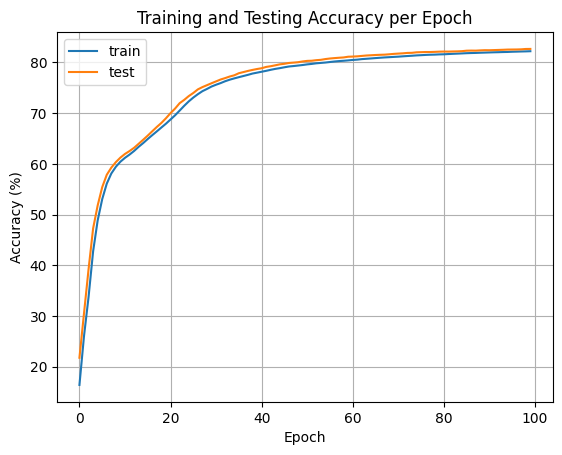

In [17]:
plot_acc(train_accuracies, test_accuracies)